# March 25th
<hr>
Progress since last meeting:

- Dissertation proposal 
- Researching all data sources 
- Updating code, incorporating enough data to have range 1958-2019
- Investigating methods to use trend decomposition to extract IAV 
- Updating models using IAV
- Added ENSO visuals

In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from scipy.fft import fft, fftfreq
from statsmodels.tsa.seasonal import seasonal_decompose

from core.data.file_processing import open_all_data, drop_na
from core.visualizations import reg_results

from sklearn import linear_model
from sklearn.model_selection import train_test_split, cross_val_score
from sklearn import preprocessing

In [2]:
df = open_all_data()
variables = ['ENSO', 'CO2_gr_MLO', 'CO2_gr_SPO',
       'Pre_global', 'Pre_South', 'Pre_Tropics', 'Pre_North', 'Temp_gl',
       'Temp_sh', 'Temp_nh', 'land_sink_global', 'land_sink_North',
       'land_sink_Tropics', 'land_sink_South', 'ocean_sink_global',
       'ocean_sink_North', 'ocean_sink_Tropics', 'ocean_sink_South']
df = drop_na(df[variables])

FileNotFoundError: [Errno 2] No such file or directory: 'data/all_data.csv'

# IAV Calculations

Piao et al. (2020):

*Six IAV extraction methods are: fast Fourier transform (FFT), ensemble empirical mode decomposition (EEMD), singular spectrum analysis (SSA), and three smoothing-filter methods (no smoothing [SMN], smoothing with a short [6 month] time window [SMS], and smoothing with a long [13 month] time window [SML]). For frequency component decomposition methods (FFT, EEMD, and SSA), the CO2 growth rate was decomposed into seasonal (<16 months), IAV (16–128 months) and long-term trend signals (>128 months). For three other methods, seasonal variability was removed by taking the difference between the CO2 concentration in 1 month and the same month in the previous year, and applying the smoothing filter of different window lengths. The linear trend was extracted with the least-square fitting*



- IAV: what if the trend isn't really a trend? Multi-annual variability? Should I decompose everything?

<AxesSubplot:>

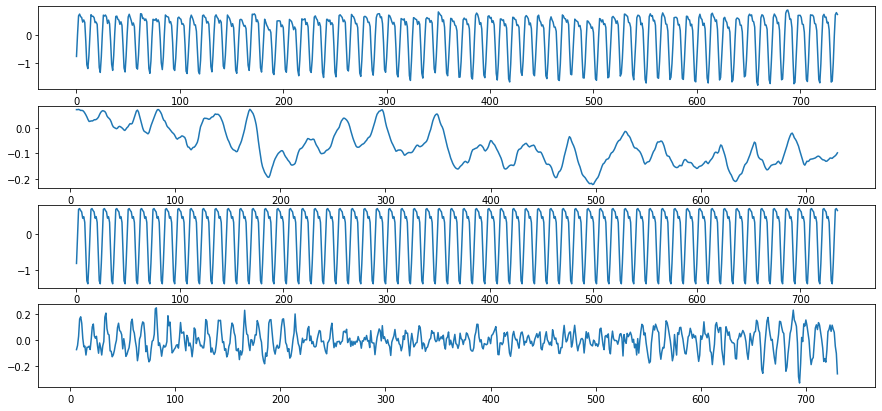

In [3]:
fig, ax = plt.subplots(4, 1, figsize=(15, 7))
decompose_result = seasonal_decompose(df['land_sink_global'], model="additive", period=12)
decompose_result.observed.plot(ax=ax[0])
decompose_result.trend.plot(ax=ax[1])
decompose_result.seasonal.plot(ax=ax[2])
decompose_result.resid.plot(ax=ax[3])

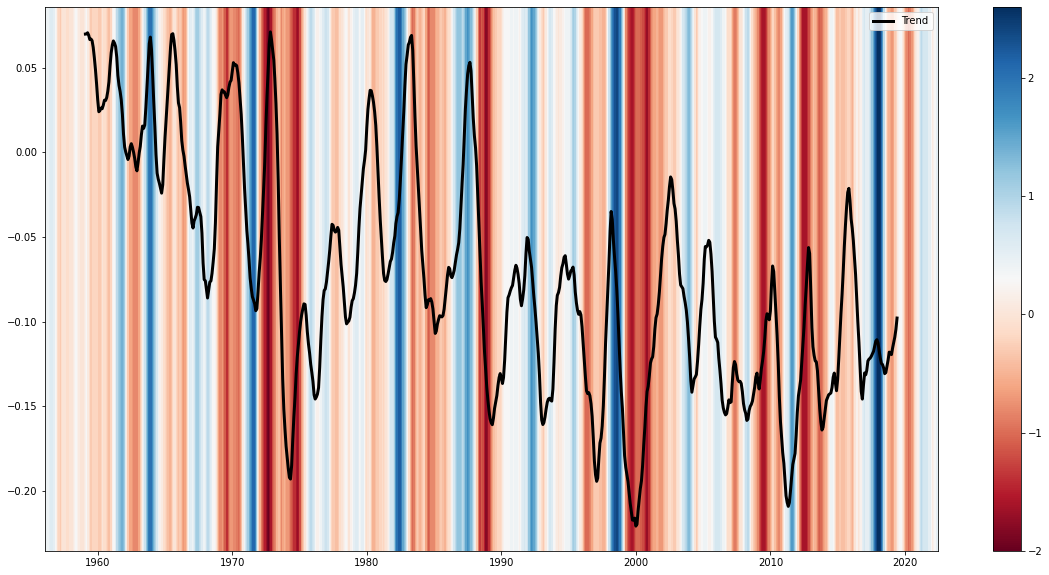

In [39]:
fig, ax = plt.subplots(figsize=(20, 10))
plt.plot(df['Date'], decompose_result.trend, label="Trend", color='k', linewidth=3)
plt.legend()
c = ax.pcolorfast(ax.get_xlim(), ax.get_ylim(), df['ENSO'].values[np.newaxis],cmap='RdBu')
fig.colorbar(c, ax=ax)
plt.show()

## Modelling with IAV

In [4]:
def iav_resid_only(df, variables=None):
    '''
    Returns the residual for each variable after removing seasonal and overall trend. 
    Uses an additive naive trend; first removes overall using moving window, then seasonal. 
    More info: https://www.statsmodels.org/stable/generated/statsmodels.tsa.seasonal.seasonal_decompose.html
    '''
    df_iav = df.copy(deep=True)
    if variables is None:
        variables = [var for var in df.columns if var not in ['Month', 'Year', 'Date', 'ENSO']]
    for var in variables:
        decompose_result = seasonal_decompose(df[var], model="additive", period=12, extrapolate_trend=1)
        df_iav[var] = decompose_result.resid
    return df_iav

def iav_with_trend(df, variables=None):
    '''
    Returns the residual for each variable after removing seasonal and overall trend. 
    Uses an additive naive trend; first removes overall using moving window, then seasonal. 
    More info: https://www.statsmodels.org/stable/generated/statsmodels.tsa.seasonal.seasonal_decompose.html
    '''
    df_iav = df.copy(deep=True)
    if variables is None:
        variables = [var for var in df.columns if var not in ['Month', 'Year', 'Date', 'ENSO']]
    for var in variables:
        decompose_result = seasonal_decompose(df[var], model="additive", period=12, extrapolate_trend=1)
        df_iav[var] = decompose_result.resid + decompose_result.trend
    return df_iav

def trend(df, variables=None):
    '''
    Returns the residual for each variable after removing seasonal and overall trend. 
    Uses an additive naive trend; first removes overall using moving window, then seasonal. 
    More info: https://www.statsmodels.org/stable/generated/statsmodels.tsa.seasonal.seasonal_decompose.html
    '''
    df_iav = df.copy(deep=True)
    if variables is None:
        variables = [var for var in df.columns if var not in ['Month', 'Year', 'Date', 'ENSO']]
    for var in variables:
        decompose_result = seasonal_decompose(df[var], model="additive", period=12, extrapolate_trend=1)
        df_iav[var] = decompose_result.trend
    return df_iav

In [5]:
df_iav_resid_only = iav_resid_only(df)
df_iav_with_trend = iav_with_trend(df)
df_trend = trend(df)

In [1]:
fig, ax = plt.subplots(1, 3, figsize=(20, 5))

sns.lineplot(x=df['Month'], y=df['land_sink_North'], hue=df['Year'], ax=ax[0])
ax[0].set_title("Land sink in the Northern exatropics")

sns.lineplot(x=df['Month'], y=df['land_sink_Tropics'], hue=df['Year'], ax=ax[1])
ax[1].set_title("Land sink in the Tropics")

sns.lineplot(x=df['Month'], y=df['land_sink_South'], hue=df['Year'], ax=ax[2])
ax[2].set_title("Land sink in the Southern exatropics")


plt.show()

fig, ax = plt.subplots(1, 3, figsize=(20, 5))

sns.lineplot(x=df_iav_with_trend['Month'], y=df_iav_with_trend['land_sink_North'], hue=df_iav_with_trend['Year'], ax=ax[0])
ax[0].set_title("Land sink in the Northern exatropics")

sns.lineplot(x=df_iav_with_trend['Month'], y=df_iav_with_trend['land_sink_Tropics'], hue=df_iav_with_trend['Year'], ax=ax[1])
ax[1].set_title("Land sink in the Tropics")

sns.lineplot(x=df_iav_with_trend['Month'], y=df_iav_with_trend['land_sink_South'], hue=df_iav_with_trend['Year'], ax=ax[2])
ax[2].set_title("Land sink in the Southern exatropics")


plt.show()

NameError: name 'plt' is not defined

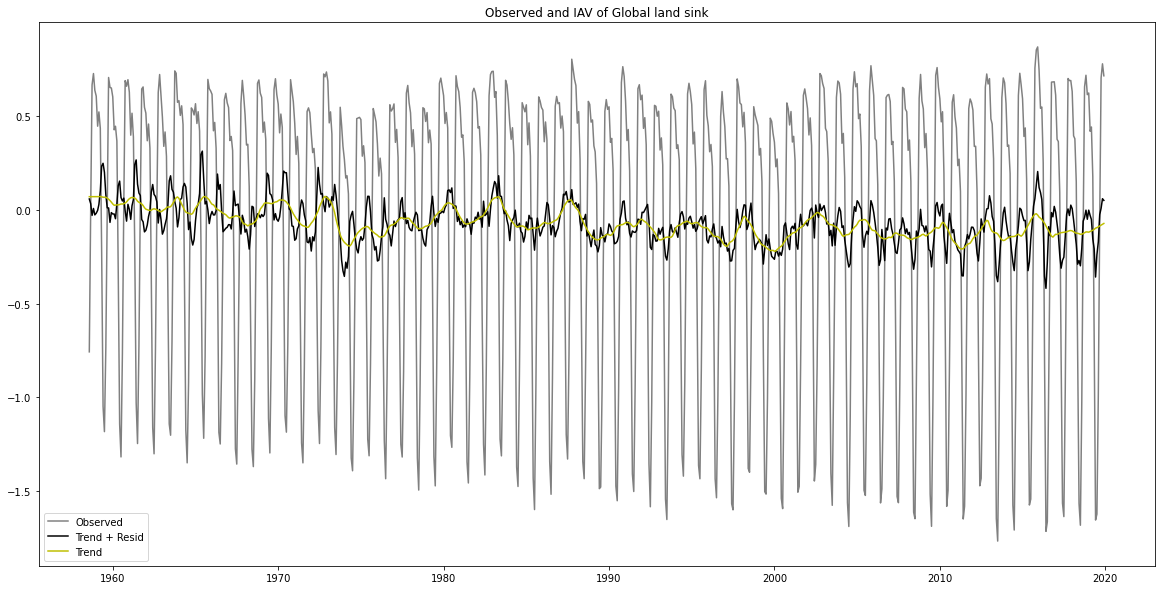

In [41]:
fig, ax = plt.subplots(figsize=(20, 10))
plt.plot(df['Date'], df['land_sink_global'], label="Observed", color='gray')
plt.plot(df['Date'], df_iav_with_trend['land_sink_global'], label="Trend + Resid", color='k')
plt.plot(df['Date'], df_trend['land_sink_global'], label="Trend", color='y')
plt.legend()
#ax.pcolorfast(ax.get_xlim(), ax.get_ylim(), df['ENSO'].values[np.newaxis],cmap='RdBu')
plt.title("Observed and IAV of Global land sink")
plt.show()

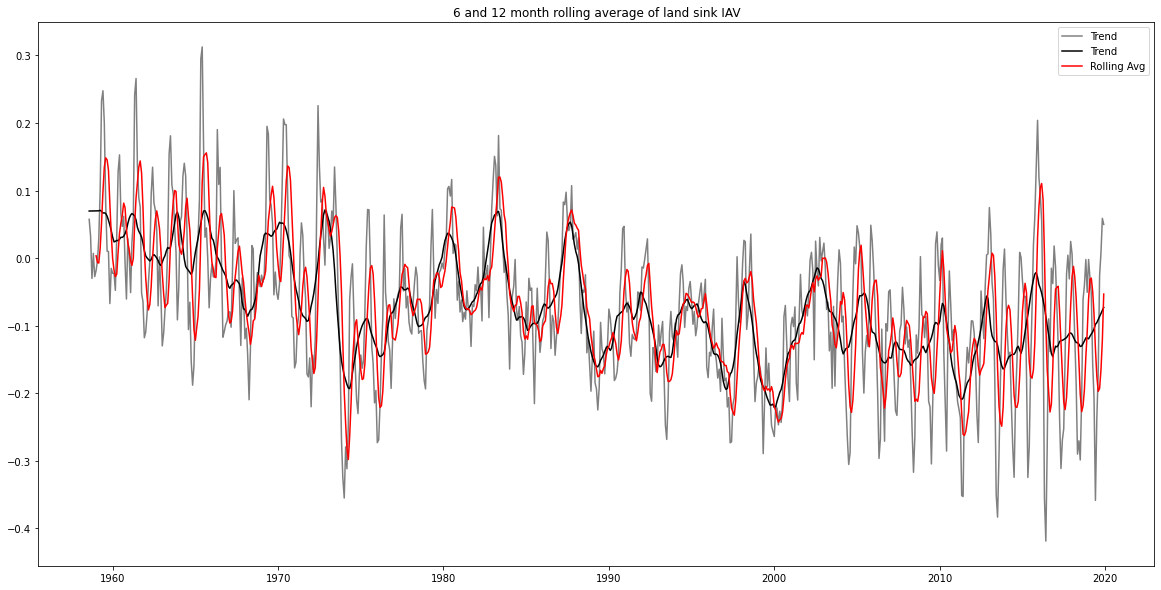

In [45]:
fig, ax = plt.subplots(figsize=(20, 10))
plt.plot(df['Date'], df_iav_with_trend['land_sink_global'], label="Trend", color='gray')
plt.plot(df['Date'], df_trend['land_sink_global'], label="Trend", color='k')
plt.plot(df['Date'], df_iav_with_trend['land_sink_global'].rolling(window=6).mean(), label="Rolling Avg", color='r')
plt.legend()
plt.title("6 and 12 month rolling average of land sink IAV")
plt.show()

In [44]:
def model_and_plot(df_show, independent_variables, dependent_variables):
    X = df_show[independent_variables]
    y = df_show[[dependent_variable]]
    reg = linear_model.LinearRegression()
    reg.fit(X, y)
    print(f"Model score: {reg.score(X, y)}")

    #reg_results(df_show, reg, X, y, dependent_variable)
    plt.figure(figsize=(20,5))
    plt.plot(df_show['Date'], reg.predict(X), label="Predicted")
    plt.plot(df_show['Date'], y, label="Actual")
    plt.legend()
    plt.title(f"Predicted and actual {dependent_variable} over time")
    plt.show()

Model score: 0.5725617152016937


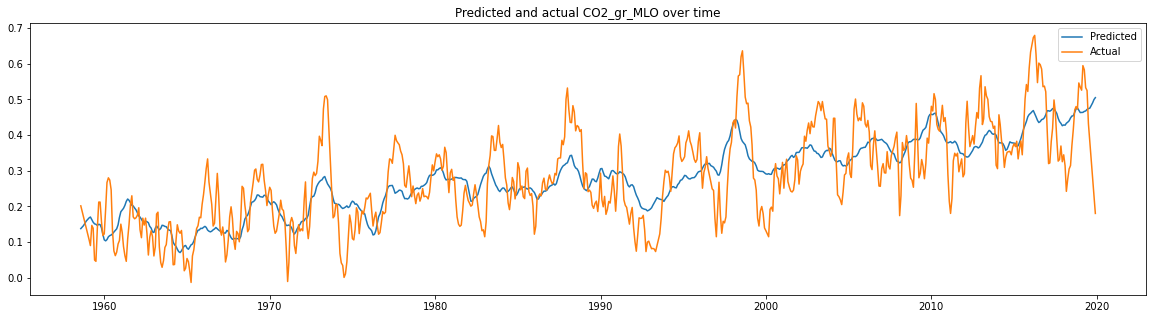

In [53]:
independent_variables = ['Pre_North', 
                         'Pre_South', 
                         'Pre_Tropics', 
                         'Temp_nh', 
                         'Temp_sh',
                         'ENSO'
                        ]
dependent_variable = 'CO2_gr_MLO'


model_and_plot(df_trend, independent_variables, dependent_variable)